In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
with open('../data/segmentation/desc.json', 'r') as f:
    j = json.loads(f.read())
    
with open('../data/segmentation/label_descriptions.json', 'r') as f:
    ld = json.loads(f.read())

all_cids = np.concatenate([e['cids'] for e in j])
uniq, cnts = np.unique(all_cids, return_counts=True)

pd.DataFrame(j).head()

,num,cids
0,15255,"[1, 9, 8]"
1,20017,"[0, 31, 31]"
2,40449,"[1, 31, 8, 32]"
3,30699,"[10, 43]"
4,9508,"[6, 1, 1, 31, 31]"


In [48]:
df = pd.DataFrame(ld['categories'])
df = pd.merge(df, pd.DataFrame({'id': uniq, 'count': cnts}), on='id').set_index('id')
df.head()


,name,supercategory,level,count
id,,,,
0,"shirt, blouse",upperbody,2,4070
1,"top, t-shirt, sweatshirt",upperbody,2,11738
2,sweater,upperbody,2,1282
3,cardigan,upperbody,2,968
4,jacket,upperbody,2,6702


Заметим, что категории сильно несбалансированы

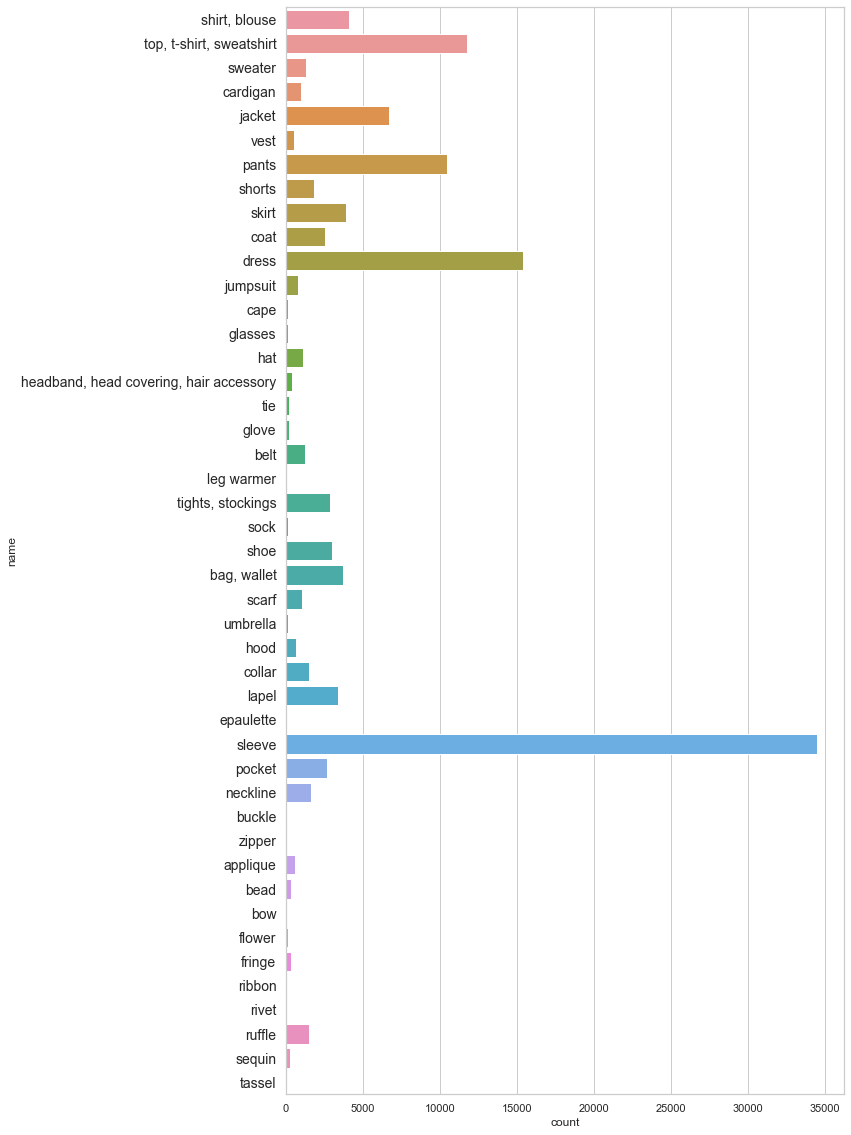

In [51]:
plt.figure(figsize=(10, 20))

sns.barplot(x='count', y='name', data=df, orient = 'h')

plt.yticks(fontsize=14)

plt.show()

Выкинем части одежды

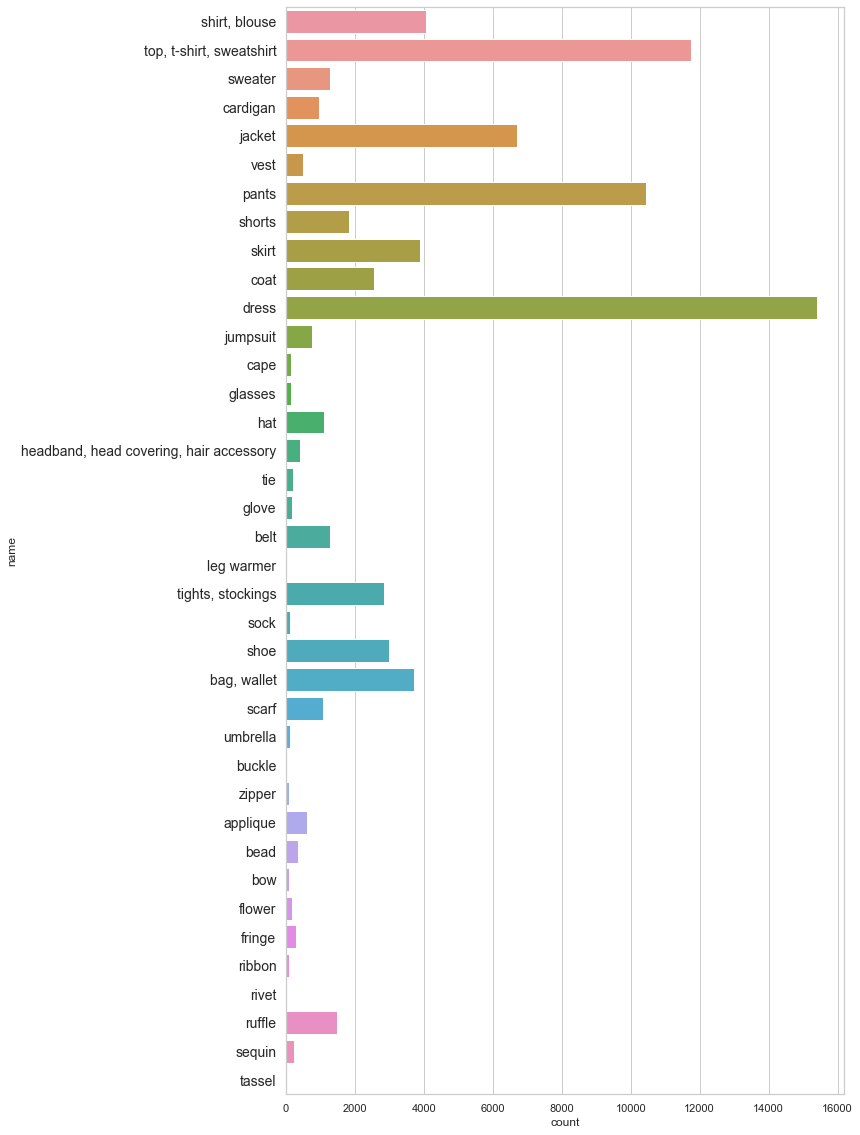

In [61]:
plt.figure(figsize=(10, 20))

sns.barplot(x='count', y='name', data=df[df['supercategory'] != 'garment parts'], orient = 'h')

plt.yticks(fontsize=14)

plt.show()

Выберем наиболее интересные

In [60]:
df

,name,supercategory,level,count
id,,,,
0,"shirt, blouse",upperbody,2,4070
1,"top, t-shirt, sweatshirt",upperbody,2,11738
2,sweater,upperbody,2,1282
3,cardigan,upperbody,2,968
4,jacket,upperbody,2,6702
5,vest,upperbody,2,504
6,pants,lowerbody,2,10439
7,shorts,lowerbody,2,1819
8,skirt,lowerbody,2,3887


In [62]:
interesting = [
    'shirt, blouse',
    'top, t-shirt, sweatshirt',
    'jacket',
    'pants',
    'shorts',
    'skirt',
    'coat',
    'dress',
    'tights, stockings',
    'shoe',
]

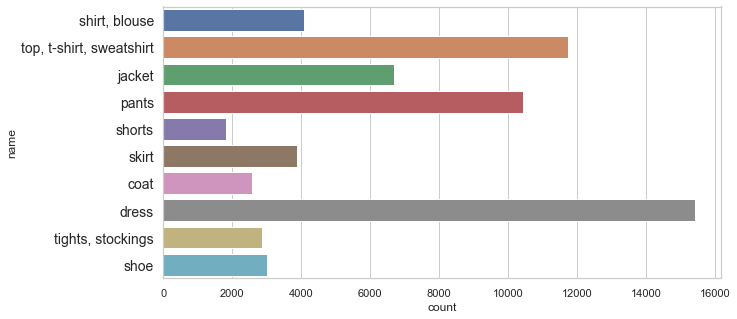

In [127]:
plt.figure(figsize=(10, 5))

sns.barplot(x='count', y='name', data=df[[e in interesting for e in df['name']]], orient = 'h')

plt.yticks(fontsize=14)

plt.show()

Найдем id интересных нам классов

In [83]:
interesting_ids = df[[e in interesting for e in df['name']]].index.to_list()
len(interesting_ids), interesting_ids

(10, [0, 1, 4, 6, 7, 8, 9, 10, 21, 23])

Подготовим описание датасета, включающее в себя только интересные нам классы

In [86]:
j_short = [
    {
        'num': e['num'],
        'cids': {
            c: i for i, c in enumerate(e['cids']) if c in interesting_ids
        }
    } for e in j
]

j_short = list(filter(lambda x: len(x['cids']) > 0, j_short))

1. * len(j_short) / len(j)

0.892415469297305

In [118]:
j_short[:2]

[{'num': 15255, 'cids': {1: 0, 9: 1, 8: 2}}, {'num': 20017, 'cids': {0: 0}}]

In [87]:
with open('../data/segmentation/desc_short.json', 'w') as f:
    f.write(json.dumps(j_short))

In [117]:
cid_to_layer = {
    idx: num for num, idx in enumerate(
        [idx for (idx, row) in df.iterrows() if row['name'] in interesting]
    )
}

cid_to_layer

{0: 0, 1: 1, 4: 2, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 21: 8, 23: 9}

In [128]:
from torch.utils import data

In [145]:
class D(data.Dataset):
    def __init__(self):
        super().__init__()
    
    def __getitem__(self, idx):
        if idx == 0:
            d = {
                'label_1': torch.tensor(1), 'label_2': torch.tensor(0)
            }
            d.update({
                'mask':  torch.tensor(1),
            })
            return d
        else:
            return {'label_1': torch.tensor(1), 'label_2': torch.tensor(2), 'mask':  torch.tensor(1)}
    
    def __len__(self):
        return 10